### Solving for a differentially private mean age of a population

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [5]:
pa = pd.read_csv("psam_p42.csv")

KeyboardInterrupt: 

In [6]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

In [7]:
def mse(true_answer, function_name, *params):
  """true_answer is either a scalar or numpy array"""
  niterations = 100_000
  return sum(np.sum((true_answer - function_name(*params))**2) for x in range(niterations)) / float(niterations)

In [8]:
def dp_mean(eps_n, eps_d, top, bot, top_sen=100.0, bot_sen=1.0):
  noisy_top = laplace_mech(top, eps_n, top_sen)
  noisy_bot = laplace_mech(bot, eps_d, bot_sen)
  return noisy_top / noisy_bot

In [9]:
"""
Solving for a differentially private mean age of a population.
1. get an estimate of the total age (by adding Laplace noiset)
2. get an estimate of the total population (by adding Laplace noise)
3. divide the two estimates

Take our total privay budget eps and split it into two pieces: 
one for estimating the numerator (eps_n)
another for estimating the denominator (eps_d)
so that eps = eps_n + eps_d

The choice of eps_n and eps_d clearly affects accuracy. Plug in 
different values for eps_n and eps_d to see how low you can make 
the estimated mse. 
"""
asn_pa = pa.query('RACASN==1 and PUMA==1000')
total_age = asn_pa.AGEP.sum()
total_population = float(asn_pa.AGEP.size)
age_sensitivity = asn_pa.AGEP.max()/2
population_sensitivity = 1.0

eps_n = 0.5 
eps_d = 0.5
assert eps_n + eps_d <= 1.0000000001, "eps_n + eps_d must be at most 1"

noisy_mean = dp_mean(eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)

error = mse(total_age/total_population, dp_mean, eps_n, eps_d, total_age, total_population, age_sensitivity, population_sensitivity)
print("a noisy mean is ", noisy_mean)
print("mse is ", error)

a noisy mean is  34.4422013929
mse is  5.01280899427


In [10]:
def avg_l1_mean(true_mean, eps, n=1000):
    total = 0
    for i in range(n):
        noisy_mean = dp_mean(eps/2, eps/2, total_age, total_population, age_sensitivity, population_sensitivity)
        accuracy = 1 - (np.linalg.norm([noisy_mean-true_mean], 1)/(2*1))
        total += accuracy
    return total/n

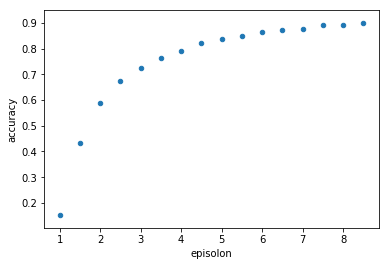

In [11]:
accuracy_df = pd.DataFrame()
eps_range = (np.arange(1.0,9.0,.5))
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_mean(total_age/total_population, x) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()